# Amazon Reviews with NLP Tokenizer and Logistic Regression
## Loading Data

In [1]:
import gzip
import json

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Musical_Instruments_5.json.gz')

## Preliminary Analysis

In [3]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [4]:
df.shape

(10261, 9)

In [5]:
df.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

1239


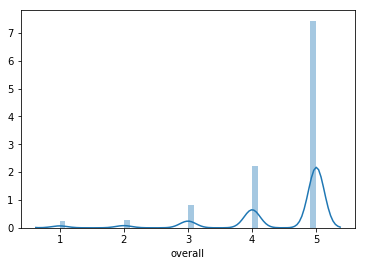

In [6]:
sns.distplot(df.overall)
print(len(df[df.overall < 4]))

The goal is to predict whether or not a review is positive based on the text of the review. Therefore, we will create a binary target variable for negative/positive reviews with the thresholds being > 4 and <= 4, respectively. While 3 would technically be considered a positive review, we will target higher ratings for the following two reasons: we are working with the assumption that reviewers who give a 3-star rating would not actively recommend the product (and, therefore, are not true positive) and we are more interested in pursuing the more polarized positive group.

In [7]:
df['target'] = np.where(df.overall >= 4, 1, 0)
df.target.sum() / len(df.target)

0.8792515349381151

The data set is skewed in favor of positive reviews with 87% of the data containing positive reviews. Therefore, we will undersample the dataset in order to create our training set.

In [8]:
# Number of data points in the minority class
number_records_negative = len(df[df.target == 0])
positive_indices = np.array(df[df.target == 1].index)
negative_indices = df[df.target == 0].index

# Out of the indices we randomly select "x" number (number_records_negative)
random_positive_indices = np.random.choice(positive_indices, number_records_negative, replace = False)
random_positive_indices = np.array(random_positive_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([negative_indices,random_positive_indices])

# Under sample dataset
under_sample_data = df.iloc[under_sample_indices,:]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'target']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'target']

# Showing ratio
print("Percentage of positive reviews: ", len(under_sample_data[under_sample_data.target == 0])/len(under_sample_data))
print("Percentage of negative reviews: ", len(under_sample_data[under_sample_data.target == 1])/len(under_sample_data))
print("Total number of reviews in resampled data: ", len(under_sample_data))

Percentage of positive reviews:  0.5
Percentage of negative reviews:  0.5
Total number of reviews in resampled data:  2478


## Model 1: Hard-Code Model on Entirety of Dataset

In [9]:
X_train, X_test, y_train_all, y_test_all = train_test_split(df['reviewText'].values, 
                 df['target'].values,        
                 test_size=0.3)

In [10]:
vect = CountVectorizer()
tf_train_all = vect.fit_transform(X_train)
tf_test_all = vect.transform(X_test)

In [11]:
p = tf_train_all[y_train_all==1].sum(0) + 1
q = tf_train_all[y_train_all==0].sum(0) + 1
r = np.log((p/p.sum()) / (q/q.sum()))
b = np.log(len(p) / len(q))

In [12]:
pre_preds = tf_test_all @ r.T + b
preds = pre_preds.T > 0
accuracy = (preds == y_test_all).mean()
print("Accuracy:", accuracy)

Accuracy: 0.890224098733355


In [13]:
preds = preds.A1
conf_matrix = confusion_matrix(preds, y_test_all)
conf_matrix

array([[  71,   36],
       [ 302, 2670]], dtype=int64)

In [14]:
recall = conf_matrix[1,1] / (conf_matrix[1,0] + conf_matrix[1,1])
print('Recall:', recall)

Recall: 0.8983849259757739


While the accuracy score of this model makes the model appear like a good performer already, a quick glance at the confusion matrix shows that the model was more willing to classify a review as positive (the majority of the reviews) at the expense of negative reviews (the minority of reviews). Let's perform this same model style on the undersampled dataset.

## Model 2: Hard-Code Model on Undersampled Dataset

In [15]:
X_train, X_test, y_train_under, y_test_under = train_test_split(under_sample_data['reviewText'].values, 
                 under_sample_data['target'].values,        
                 test_size=0.3)

In [16]:
vect = CountVectorizer()
tf_train_under = vect.fit_transform(X_train)
tf_test_under = vect.transform(X_test)

In [17]:
p = tf_train_under[y_train_under==1].sum(0) + 1
q = tf_train_under[y_train_under==0].sum(0) + 1
r = np.log((p/p.sum()) / (q/q.sum()))
b = np.log(len(p) / len(q))

In [18]:
pre_preds = tf_test_under @ r.T + b
preds = pre_preds.T > 0
accuracy = (preds == y_test_under).mean()
print("Accuracy:", accuracy)

Accuracy: 0.7204301075268817


In [19]:
preds = preds.A1
conf_matrix = confusion_matrix(preds, y_test_under)
conf_matrix

array([[284, 117],
       [ 91, 252]], dtype=int64)

In [20]:
recall = conf_matrix[1,1] / (conf_matrix[1,0] + conf_matrix[1,1])
print('Recall:', recall)

Recall: 0.7346938775510204


As was expected, when running the model on a evenly distributed dataset in terms of its target variable, the accuracy dropped; however, the model improved in predicting true negatives.

## Model 3: Logistic Regression on Entirety of Dataset

In [21]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train_all, y_train_all)
preds = model.predict(tf_test_all)
accuracy = (preds == y_test_all).mean()
print("Accuracy:", accuracy)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.8876258525495291


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [22]:
conf_matrix = confusion_matrix(preds, y_test_all)
conf_matrix

array([[  99,   72],
       [ 274, 2634]], dtype=int64)

In [23]:
recall = conf_matrix[1,1] / (conf_matrix[1,0] + conf_matrix[1,1])
print('Recall:', recall)

Recall: 0.905777166437414


## Model 4: Logistic Regression on Undersampled Dataset

In [24]:
model = LogisticRegression(C=0.2, dual=True)
model.fit(tf_train_under, y_train_under)
preds = model.predict(tf_test_under)
accuracy = (preds == y_test_under).mean()
print("Accuracy:", accuracy)

Accuracy: 0.717741935483871


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [25]:
conf_matrix = confusion_matrix(preds, y_test_under)
conf_matrix

array([[261,  96],
       [114, 273]], dtype=int64)

In [26]:
recall = conf_matrix[1,1] / (conf_matrix[1,0] + conf_matrix[1,1])
print('Recall:', recall)

Recall: 0.7054263565891473


# Conclusion
In terms of accuracy, using the count vectorizer/logistic regression model performed slightly better than the count vectorizer/hard-code model. However, in terms of recall, the logistic model only performed better on the entire dataset and not on the undersampled dataset.

If one were to apply one of the models on an untagged set of reviews, it would be preferred to use the undersampled model in order to avoid the inherent bias of having a larger positive review group.